In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import unconstr_solvers as solvers
import step_size as ss
import utils
import scipy.optimize as scopt

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 49.999999999999986


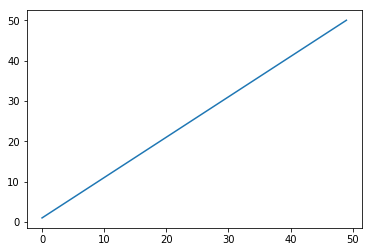

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.plot(np.sort(eig_vals))

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.ConjugateGradientQuad(A, b),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.041642702600166503
Function value = -4.103406500964356
	 Newton
Convergence in 1 iterations
Norm of gradient = 4.02338998828857e-14
Function value = -4.103845996375412
	 CG quad
Convergence in 36 iterations
Norm of gradient = 8.03229468574531e-07
Function value = -4.103845996375403
	 CG FR
Convergence in 69 iterations
Norm of gradient = 9.055398142914935e-07
Function value = -4.103845996375374
	 BB 1
Convergence in 74 iterations
Norm of gradient = 9.247352000860896e-07
Function value = -4.103845996375298


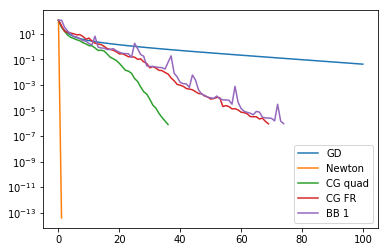

In [7]:
plt.figure()
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend()

### Matrix with high condition number and clusterized spectrum

Condition number = 1000.000000000423


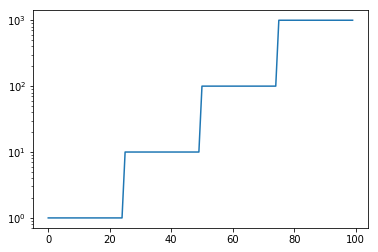

In [8]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.semilogy(np.sort(eig_vals))

In [9]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [10]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.ConjugateGradientQuad(A, b),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [11]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [12]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 15.56846669320479
Function value = -1.0505110680935639
	 Newton
Convergence in 1 iterations
Norm of gradient = 1.2604326475116955e-12
Function value = -13.918654581322755
	 CG quad
Convergence in 4 iterations
Norm of gradient = 7.235229272035026e-07
Function value = -13.918654581322814
	 CG FR
Convergence in 100 iterations
Norm of gradient = 0.9529578922118918
Function value = -13.488108335410239
	 BB 1
Convergence in 50 iterations
Norm of gradient = 7.644380255029713e-08
Function value = -13.918654581322432


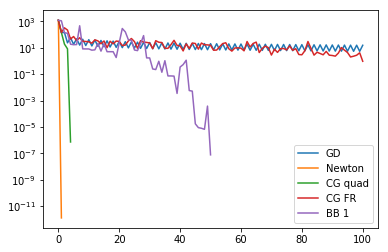

In [13]:
plt.figure()
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend()

## Analytical center of the set of inequalities

In [14]:
n = 1000
m = 500
A = np.random.rand(n, m) * 10

In [15]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), \
                          axis=1) + 2 * x / (1 - np.power(x, 2))

hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [16]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [17]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [18]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 25 iterations
Norm of gradient = 7.5000901412157835e-06
Function value = -3632.8020838588286
	 Newton
Convergence in 14 iterations
Norm of gradient = 1.496612699966399e-08
Function value = -3632.8020838588327
	 CG FR
Convergence in 17 iterations
Norm of gradient = 7.669063592940417e-06
Function value = -3632.8020838588272
	 BB 1
Convergence in 9 iterations
Norm of gradient = 6.931569285120925e-06
Function value = -3632.8020838588277


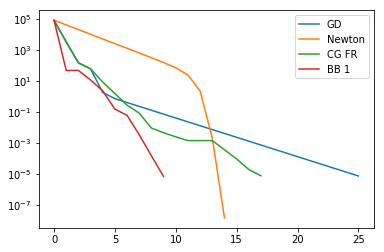

In [19]:
plt.figure()
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend()

## Toy logistic regression with L2 regularization

In [20]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 2.284931291139101


In [21]:
m_dict = {
     "GD": solvers.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), utils.Restart(10)),
     "BB 1": solvers.BarzilaiBorwein(f, grad_f, init_alpha=1e-4, type=1),
    }

In [22]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [23]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.0047644273061262996
Function value = 0.49808283155301525
	 Newton
Convergence in 22 iterations
Norm of gradient = 5.627069204945897e-06
Function value = 0.4980758052073442
	 CG FR
Convergence in 56 iterations
Norm of gradient = 6.460967729582419e-06
Function value = 0.49807580521668743
	 BB 1
Convergence in 56 iterations
Norm of gradient = 7.436487084327048e-06
Function value = 0.49807580521037786


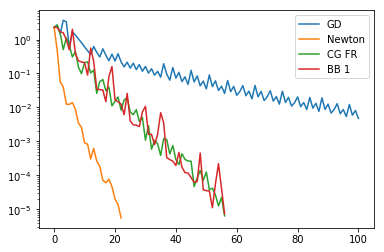

In [24]:
plt.figure()
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend()